## Load data and imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
sys.path.append('d:\\Hacks\\re_new')

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
train.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


In [8]:
train.shape

(909604, 16)

In [9]:
train2 = pd.read_csv('../data/raw2/train.csv')
test2 = pd.read_csv('../data/raw2/test.csv')
train2.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


In [10]:
test.describe()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
count,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000
mean,525.681746,537.293596,25.591148,931.053027,60.749563,527.773128,31.762555,31.699346,111.004157,133.611637,199.505514,5.892971,0.651781
std,474.203174,481.896219,8.018596,193.601381,9.701372,472.053401,3.932439,3.545439,78.090995,91.107676,104.425823,1.974445,0.316810
min,0.000000,0.000146,5.591293,0.000000,25.522359,0.000000,11.114894,16.558018,-269.505871,-5.458648,0.692485,0.910083,0.000000
25%,149.410290,155.873531,17.107900,770.538574,54.956130,147.451206,29.923965,30.288546,81.514672,96.032887,99.223911,4.398779,0.431627
50%,379.413684,383.434929,27.946935,883.336072,60.050446,392.406166,31.773077,31.970005,91.934136,107.528205,232.892194,5.633314,0.583164
75%,783.186417,802.224597,32.173036,1123.579971,65.753130,796.195534,33.480130,33.550202,124.955650,154.144882,287.370643,7.090882,0.798584
max,1999.976318,1999.970825,47.886087,1249.782534,129.628894,1999.981852,52.739494,48.395732,505.596202,591.706401,359.229909,19.607500,8.593856


In [11]:
test2.describe()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
count,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000,303202.000000
mean,525.681746,537.293596,25.591148,931.053027,60.749563,527.773128,31.762555,31.699346,111.004157,133.611637,199.505514,5.892971,0.651781
std,474.203174,481.896219,8.018596,193.601381,9.701372,472.053401,3.932439,3.545439,78.090995,91.107676,104.425823,1.974445,0.316810
min,0.000000,0.000146,5.591293,0.000000,25.522359,0.000000,11.114894,16.558018,-269.505872,-5.458648,0.692485,0.910083,0.000000
25%,149.410290,155.873531,17.107900,770.538574,54.956130,147.451206,29.923965,30.288546,81.514672,96.032887,99.223911,4.398779,0.431627
50%,379.413684,383.434929,27.946935,883.336072,60.050446,392.406166,31.773077,31.970005,91.934136,107.528205,232.892194,5.633314,0.583164
75%,783.186417,802.224597,32.173036,1123.579971,65.753130,796.195534,33.480130,33.550202,124.955650,154.144882,287.370643,7.090882,0.798584
max,1999.976318,1999.970825,47.886087,1249.782534,129.628894,1999.981852,52.739494,48.395732,505.596202,591.706401,359.229909,19.607500,8.593856


## Explore

<AxesSubplot:xlabel='Target', ylabel='Density'>

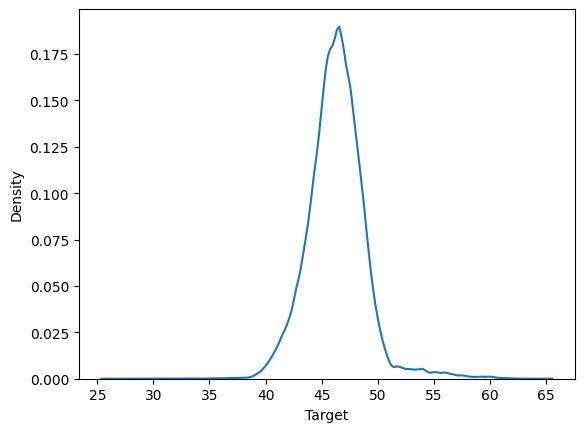

In [14]:
sns.kdeplot(train.Target)

In [16]:
train.columns

Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id', 'Target'],
      dtype='object')

In [17]:
train.wind_direction_raw

0         280.864782
1         299.552460
2          84.960106
3          87.261119
4         313.724818
             ...    
909599    189.901812
909600     93.417590
909601    230.988398
909602     65.408801
909603     11.127739
Name: wind_direction_raw, Length: 909604, dtype: float64

In [21]:
train.turbine_id.value_counts(normalize=True)

Turbine_15     0.063817
Turbine_18     0.063645
Turbine_120    0.063494
Turbine_97     0.063416
Turbine_158    0.063181
Turbine_108    0.063105
Turbine_105    0.063040
Turbine_103    0.062603
Turbine_14     0.062592
Turbine_139    0.062588
Turbine_13     0.062503
Turbine_20     0.062140
Turbine_19     0.061946
Turbine_123    0.061813
Turbine_10     0.060564
Turbine_01     0.059554
Name: turbine_id, dtype: float64

In [22]:
test.turbine_id.value_counts(normalize=True)

Turbine_15     0.064422
Turbine_97     0.063789
Turbine_158    0.063694
Turbine_18     0.063687
Turbine_105    0.063680
Turbine_120    0.063047
Turbine_108    0.062734
Turbine_103    0.062605
Turbine_14     0.062533
Turbine_20     0.062444
Turbine_139    0.062302
Turbine_13     0.061784
Turbine_19     0.061701
Turbine_123    0.061619
Turbine_10     0.060465
Turbine_01     0.059495
Name: turbine_id, dtype: float64

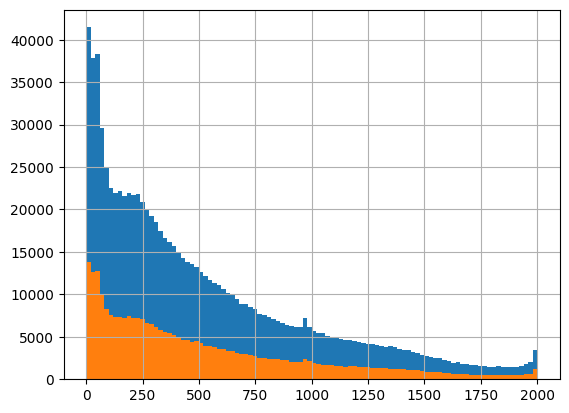

In [26]:
train.active_power_calculated_by_converter.hist(bins=100);
test.active_power_calculated_by_converter.hist(bins=100);

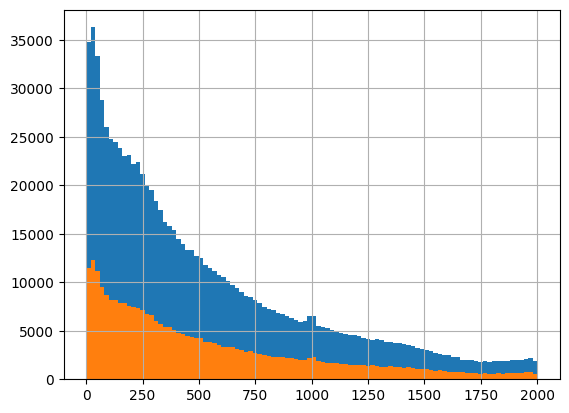

In [28]:
train.active_power_raw.hist(bins=100);
test.active_power_raw.hist(bins=100);

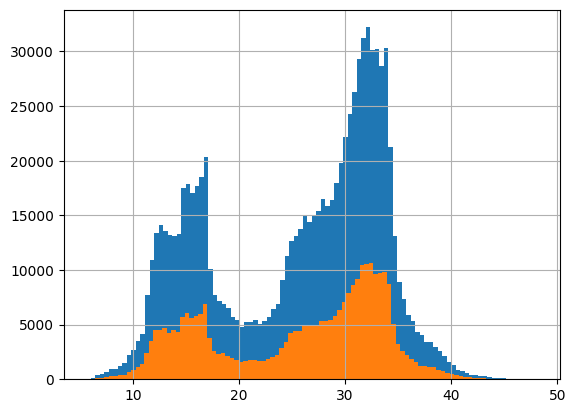

In [29]:
train.ambient_temperature.hist(bins=100);
test.ambient_temperature.hist(bins=100);

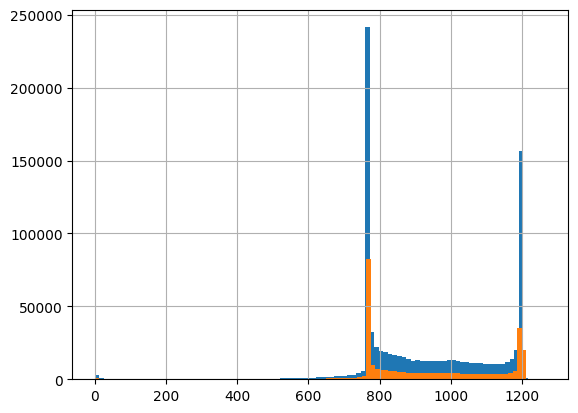

In [34]:
train.generator_speed.hist(bins=100);
test.generator_speed.hist(bins=100);

In [39]:
train.columns

Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id', 'Target'],
      dtype='object')

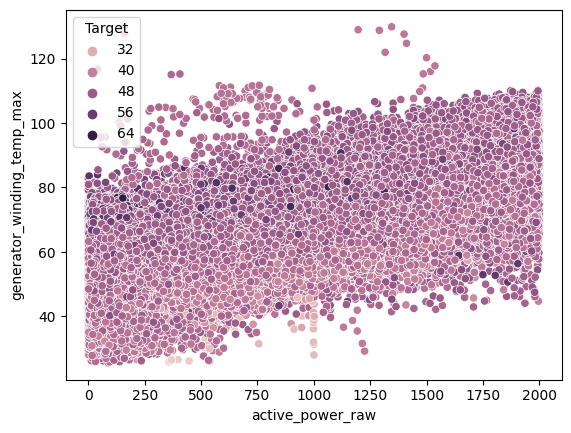

In [40]:
sns.scatterplot(x='active_power_raw', y='generator_winding_temp_max', hue='Target', data=train);

In [ ]:
sns.scatterplot(x='active_power_raw', y='nacelle_temp', hue='Target', data=train);

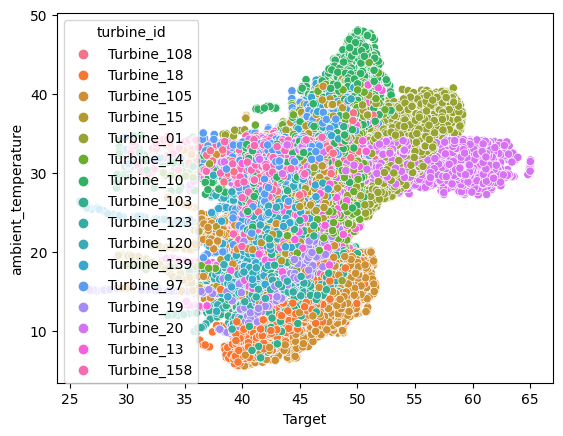

In [42]:
sns.scatterplot(x='Target', y='ambient_temperature', hue='turbine_id', data=train);

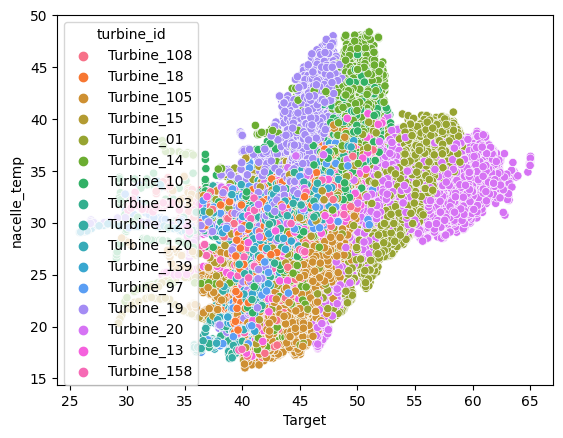

In [43]:
sns.scatterplot(x='Target', y='nacelle_temp', hue='turbine_id', data=train);

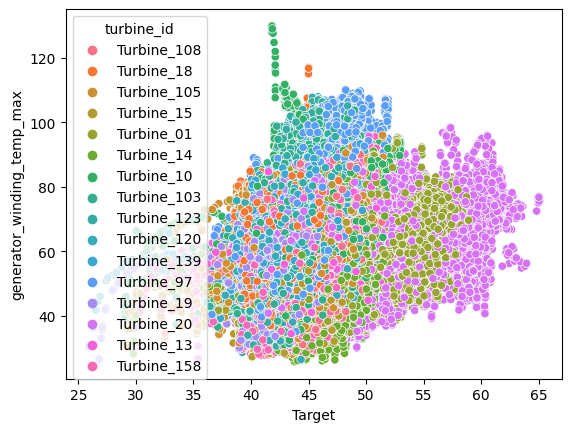

In [44]:
sns.scatterplot(x='Target', y='generator_winding_temp_max', hue='turbine_id', data=train);

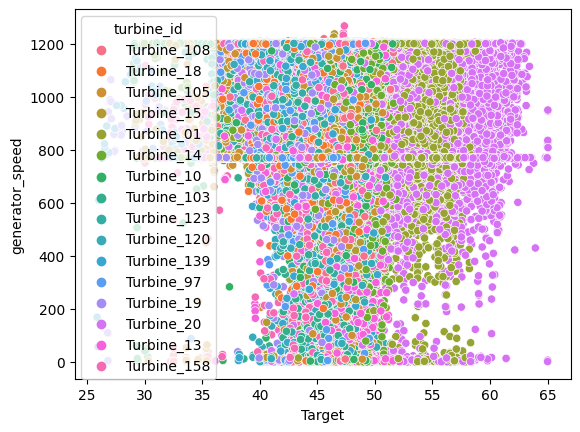

In [45]:
sns.scatterplot(x='Target', y='generator_speed', hue='turbine_id', data=train);

In [ ]:
# reactive power calculated , reactive power
# wind spped, active power calc , active power


# target, ambienttemp, nacelletemp